# Итоговое задание. Классификация (KNN)
## Вариант: базовый (KNN)

### Задание 1. Загрузка и проверка данных
1) Загрузка предобработанных данных  
2) Проверка уникальности order_id  
3) Проверка наличия обязательных колонок  
4) Определение X и y

In [51]:
import sys
import pandas as pd

df = None

# Загрузка данных (Colab / локально)
if "google.colab" in sys.modules:
    from google.colab import drive  # type: ignore

    drive.mount("/content/drive")
    df = pd.read_csv("/content/drive/MyDrive/module_6/data/preprocessed_orders.csv")
else:
    df = pd.read_csv("data/preprocessed_orders.csv")


In [52]:
df.head()


,Unnamed: 0,store_id,order_id,product_id,price,profit,delivery_distance,planned_prep_time,region_id,order_price,items_count,prepared_on_time
0,0,5014.0,20562761.0,41.0,7.04,45.504,2205.0,15.0,683.0,30.49,2.0,1.0
1,1,5014.0,20562761.0,31.0,23.45,45.504,2205.0,15.0,683.0,30.49,2.0,1.0
2,2,3856.0,20562753.0,7.0,51.94,30.336,1368.0,10.0,683.0,240.78,2.0,1.0
3,3,3856.0,20562753.0,4.0,98.96,30.336,1368.0,10.0,683.0,240.78,2.0,1.0
4,4,10825.0,20562723.0,12.0,85.99,43.608,459.0,20.0,683.0,85.99,1.0,1.0


In [53]:
df.shape


(15264, 12)

In [54]:
if not df["order_id"].is_unique:
    print("order_id не уникален")
    df = df.groupby("order_id", as_index=False).agg(
        store_id=("store_id", "first"),
        region_id=("region_id", "first"),
        order_price=("order_price", "sum"),
        profit=("profit", "sum"),
        delivery_distance=("delivery_distance", "first"),
        planned_prep_time=("planned_prep_time", "first"),
        items_count=("items_count", "sum"),
        prepared_on_time=(
            "prepared_on_time",
            "max",
        ),
    )

    if not df["order_id"].is_unique:
        raise RuntimeError("всё плохо")
    print("Теперь order_id уникален:", df["order_id"].is_unique)


order_id не уникален
Теперь order_id уникален: True


In [55]:
required_columns = [
    "store_id",
    "order_price",
    "profit",
    "delivery_distance",
    "planned_prep_time",
    "region_id",
    "items_count",
    "prepared_on_time",
]

missing_columns = set(required_columns) - set(df.columns)

print("Отсутствующие столбцы:", missing_columns)


Отсутствующие столбцы: set()


In [56]:
# Информация о типах и пропусках
df[required_columns].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5959 entries, 0 to 5958
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   store_id           5959 non-null   float64
 1   order_price        5959 non-null   float64
 2   profit             5959 non-null   float64
 3   delivery_distance  5959 non-null   float64
 4   planned_prep_time  5959 non-null   float64
 5   region_id          5959 non-null   float64
 6   items_count        5959 non-null   float64
 7   prepared_on_time   5959 non-null   float64
dtypes: float64(8)
memory usage: 372.6 KB


In [57]:
X = df[
    [
        "store_id",
        "order_price",
        "profit",
        "delivery_distance",
        "planned_prep_time",
        "region_id",
        "items_count",
    ]
]

y = df["prepared_on_time"]

print("Форма X:", X.shape)
print("Форма y:", y.shape)

# Проверка распределения целевой переменной
y.value_counts(normalize=True)


Форма X: (5959, 7)
Форма y: (5959,)


prepared_on_time
1.0    0.835543
0.0    0.164457
Name: proportion, dtype: float64

### Задание 2. Масштабирование и разбиение

1) Масштабирование признаков  
2) Разбиение данных на train / test  
3) Проверка форм и корректности


In [58]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

RANDOM_STATE = 42


In [59]:
feature_cols = [
    "store_id",
    "order_price",
    "profit",
    "delivery_distance",
    "planned_prep_time",
    "region_id",
    "items_count",
]

X = df[feature_cols]
y = df["prepared_on_time"]

print("Форма X:", X.shape)
print("Форма y:", y.shape)


Форма X: (5959, 7)
Форма y: (5959,)


In [60]:
TEST_SIZE: float = 0.2

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y,
)

print("Train X:", X_train.shape)
print("Test  X:", X_test.shape)

Train X: (4767, 7)
Test  X: (1192, 7)


In [61]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [62]:
import pandas as pd

X_train_scaled_df = pd.DataFrame(
    X_train_scaled,
    columns=feature_cols,
    index=X_train.index,
)

X_train_scaled_df.describe()


,store_id,order_price,profit,delivery_distance,planned_prep_time,region_id,items_count
count,4.767000e+03,4.767000e+03,4.767000e+03,4.767000e+03,4.767000e+03,4.767000e+03,4.767000e+03
mean,1.050834e-16,7.452724e-19,-1.147720e-16,1.132814e-16,-2.280534e-16,-3.101079e-15,-2.310345e-17
std,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00
min,-1.356573e+00,-6.459782e-01,-6.143681e-01,-1.412129e+00,-2.634419e+00,-7.868691e-01,-6.585819e-01
25%,-9.476590e-01,-5.573240e-01,-4.944429e-01,-7.225211e-01,-3.770221e-01,-7.868691e-01,-6.585819e-01
50%,-1.901406e-01,-3.745298e-01,-3.111123e-01,-2.555756e-01,-3.770221e-01,-5.870819e-01,-4.050520e-01
75%,8.898373e-01,1.455732e-01,8.882021e-02,4.650112e-01,8.770874e-01,1.211003e+00,1.749765e-02
max,1.749497e+00,1.122644e+01,1.598834e+01,4.365797e+00,8.401745e+00,2.609514e+00,1.142634e+01


In [63]:
print(f"""###########################################
Распределение y (train): {y_train.value_counts(normalize=True)}

###########################################
Распределение y (test): {y_test.value_counts(normalize=True)}
""")


###########################################
Распределение y (train): prepared_on_time
1.0    0.835536
0.0    0.164464
Name: proportion, dtype: float64

###########################################
Распределение y (test): prepared_on_time
1.0    0.83557
0.0    0.16443
Name: proportion, dtype: float64



### Задание 3. Подбор гиперпараметров KNN

1) Настройка сетки гиперпараметров  
2) Подбор с помощью GridSearchCV  
3) Вывод лучших параметров и качества на кросс-валидации

In [64]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV


In [65]:
param_grid = {
    "n_neighbors": [3, 5, 7, 9, 11, 15],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan", "minkowski"],
    "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
}


In [66]:
knn = KNeighborsClassifier()

grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    verbose=1,
)


In [67]:
grid_search.fit(X_train_scaled, y_train)


Fitting 5 folds for each of 144 candidates, totalling 720 fits


,estimator,KNeighborsClassifier()
,param_grid,"{'algorithm': ['auto', 'ball_tree', ...], 'metric': ['euclidean', 'manhattan', ...], 'n_neighbors': [3, 5, ...], 'weights': ['uniform', 'distance']}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,15


In [68]:
print("Лучшие гиперпараметры:")
print(grid_search.best_params_)

print("\nЛучшая средняя accuracy на CV:")
print(round(grid_search.best_score_, 4))

Лучшие гиперпараметры:
{'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'uniform'}

Лучшая средняя accuracy на CV:
0.8347


In [69]:
results_df = pd.DataFrame(grid_search.cv_results_)

results_df[
    [
        "mean_test_score",
        "std_test_score",
        "param_n_neighbors",
        "param_weights",
        "param_metric",
        "param_algorithm",
    ]
].sort_values("mean_test_score", ascending=False).head()


,mean_test_score,std_test_score,param_n_neighbors,param_weights,param_metric,param_algorithm
10,0.834697,0.001296,15,uniform,euclidean,auto
106,0.834697,0.001296,15,uniform,minkowski,kd_tree
142,0.834697,0.001296,15,uniform,minkowski,brute
118,0.834697,0.001296,15,uniform,euclidean,brute
82,0.834697,0.001296,15,uniform,euclidean,kd_tree


### Задание 4. Обучение и оценка KNN

1) Обучение финальной модели с лучшими гиперпараметрами  
2) Оценка качества на тестовой выборке  
3) Вывод основных метрик и classification_report  
4) Краткие выводы


In [70]:
best_knn = grid_search.best_estimator_

print("Используемые гиперпараметры:")
print(best_knn)


Используемые гиперпараметры:
KNeighborsClassifier(metric='euclidean', n_neighbors=15)


In [71]:
y_pred = best_knn.predict(X_test_scaled)


In [73]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Метрики качества на тестовой выборке:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

print("Classification report:")
print(classification_report(y_test, y_pred))

Метрики качества на тестовой выборке:
Accuracy : 0.8347
Precision: 0.8354
Recall   : 0.9990
F1-score : 0.9099
Classification report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       196
         1.0       0.84      1.00      0.91       996

    accuracy                           0.83      1192
   macro avg       0.42      0.50      0.45      1192
weighted avg       0.70      0.83      0.76      1192



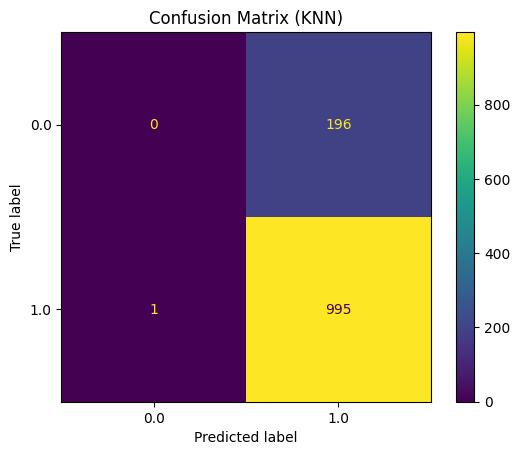

In [74]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix (KNN)")
plt.show()


### Задание 5. Визуализация влияния числа соседей (k)

1) Обучение KNN с разными значениями n_neighbors  
2) Оценка accuracy на кросс-валидации  
3) Построение графика accuracy(k)  
4) Краткий комментарий по форме кривой


In [75]:
best_k = grid_search.best_params_["n_neighbors"]

k_values = range(max(1, best_k - 5), best_k + 6)
k_values


range(10, 21)

In [76]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(
        n_neighbors=k,
        weights=grid_search.best_params_["weights"],
        metric=grid_search.best_params_["metric"],
        algorithm=grid_search.best_params_["algorithm"],
    )

    scores = cross_val_score(
        knn,
        X_train_scaled,
        y_train,
        cv=5,
        scoring="accuracy",
        n_jobs=-1,
    )

    cv_scores.append(scores.mean())

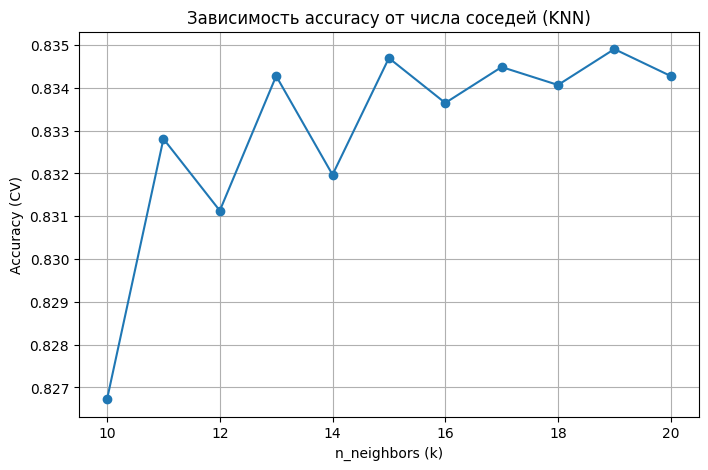

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(k_values, cv_scores, marker="o")
plt.xlabel("n_neighbors (k)")
plt.ylabel("Accuracy (CV)")
plt.title("Зависимость accuracy от числа соседей (KNN)")
plt.grid(True)
plt.show()


In [78]:
pd.DataFrame(
    {
        "n_neighbors": list(k_values),
        "cv_accuracy": cv_scores,
    }
)


,n_neighbors,cv_accuracy
0,10,0.826725
1,11,0.832809
2,12,0.831130
3,13,0.834277
4,14,0.831969
5,15,0.834697
6,16,0.833647
7,17,0.834487
8,18,0.834067
9,19,0.834906
